In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)


In [3]:
mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
deposit_data = density_data

deposit_data = deposit_data.dropna(subset=[mineral] + filter)
df1 = deposit_data
variable=mineral

In [4]:
two_composite_1covariates = deposit_data

# Calculate the percentage of missing values for each variable
missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

# Identify variables with more than 15% missing values
variables_to_remove = missing_percentage[missing_percentage > 5].index

# Drop the identified variables from the DataFrame
two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [5]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [6]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm']

deposit_data.describe()
deposit_data.fillna(0, inplace=True)
deposit_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\3867690008.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [7]:
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])


C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\1488387108.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\1488387108.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\1488387108.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [8]:
# lon = df1.values[:,4]
# lat = df1.values[:,5]
# az = df1.values[:,6]

# normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
# normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
# normalized_az = (az-min(az))/(max(az)-min(az))
# N = lon.shape[0]

In [9]:

lon = df1.values[:, 4]
lat = df1.values[:, 5]
az = df1.values[:, 6]

# Subtract the minimum values for each array
lon = lon - np.min(lon)
lat = lat - np.min(lat)
az = az - np.min(az)

# Calculate the overall minimum and maximum values from the entire dataset
min_value = np.min([np.min(lon), np.min(lat), np.min(az)])
max_value = np.max([np.max(lon), np.max(lat), np.max(az)])

# Scale the arrays to (0, 1) using the calculated minimum and maximum values
normalized_lon = (lon - min_value) / (max_value - min_value)
normalized_lat = (lat - min_value) / (max_value - min_value)
normalized_az = (az - min_value) / (max_value - min_value)

N = lon.shape[0]

# Display the normalized arrays
print("Normalized Lon:", normalized_lon)
print("Normalized Lat:", normalized_lat)
print("Normalized Az:", normalized_az)


Normalized Lon: [0.43781378776682156 0.43806121898106964 0.4481744075146454 ...
 0.6290106350432114 0.6289206600563835 0.6288351838188028]
Normalized Lat: [0.5098162710765618 0.5097892785806601 0.5087995537240868 ...
 0.0008772561228813492 0.0004363786870266015 0.0]
Normalized Az: [0.46145471558890383 0.4605909557141493 0.42606755322005485 ...
 0.4312051249751051 0.43042684133795656 0.4296440589514603]


In [10]:
num_basis = [10**2,19**2,37**2]
knots_1dx = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
knots_1dy = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]


##Wendland kernel
basis_size = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_x, knots_y= np.meshgrid(knots_1dx[res],knots_1dy[res])
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(np.vstack((normalized_lon,normalized_lat)).astype(float).T-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + basis_size] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + basis_size] = 0
    basis_size = basis_size + num_basis[res]

In [11]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi.shape[1]):
    if sum(phi[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi,idx_zero,1)
print(phi.shape)
print(phi_reduce.shape)

(2618, 1830)
(2618, 876)


In [12]:

len_phi = np.shape(phi_reduce)[1]

# Create a DataFrame
df = pd.DataFrame(phi_reduce, columns=[f'phi_{i}' for i in range(len_phi)])

# Display the DataFrame
print(df)


      phi_0  phi_1     phi_2     phi_3     phi_4     phi_5  phi_6  phi_7  \
0       0.0    0.0  0.000000  0.000000  0.000000  0.000000    0.0    0.0   
1       0.0    0.0  0.000000  0.000000  0.000000  0.000000    0.0    0.0   
2       0.0    0.0  0.000000  0.000000  0.000000  0.000000    0.0    0.0   
3       0.0    0.0  0.000000  0.000000  0.000000  0.000000    0.0    0.0   
4       0.0    0.0  0.000000  0.000000  0.000000  0.000000    0.0    0.0   
...     ...    ...       ...       ...       ...       ...    ...    ...   
2613    0.0    0.0  0.003732  0.465702  0.815398  0.038680    0.0    0.0   
2614    0.0    0.0  0.003761  0.466644  0.814772  0.038515    0.0    0.0   
2615    0.0    0.0  0.003789  0.467519  0.814138  0.038356    0.0    0.0   
2616    0.0    0.0  0.003818  0.468412  0.813421  0.038187    0.0    0.0   
2617    0.0    0.0  0.003846  0.469239  0.812696  0.038025    0.0    0.0   

         phi_8     phi_9  ...  phi_866  phi_867  phi_868  phi_869  phi_870  \
0     0.0

In [13]:
df_reset = df.reset_index(drop=True)
deposit_data_reset = deposit_data.reset_index(drop=True)

# Concatenate along columns
deposit_data = pd.concat([deposit_data_reset, df], axis=1)

# Display the resulting DataFrame
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total,...,phi_866,phi_867,phi_868,phi_869,phi_870,phi_871,phi_872,phi_873,phi_874,phi_875
0,KV-NME001,0.437814,0.509816,0.461455,0.400922,0.8800,0.127305,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KV-NME001,0.438061,0.509789,0.460591,0.410138,0.8800,0.160479,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KV-NME001,0.448174,0.508800,0.426068,0.442396,0.9900,0.128743,0.250,0.066667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KV-NME001,0.448431,0.508777,0.425204,0.442396,0.9900,0.141317,0.375,0.133333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KV-NME001,0.448683,0.508755,0.424340,0.442396,0.9900,0.153293,0.500,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,KV365,0.629186,0.001755,0.432766,0.543779,0.9235,0.078443,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2614,KV365,0.629096,0.001314,0.431988,0.539171,0.9235,0.074850,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2615,KV365,0.629011,0.000877,0.431205,0.543779,0.8584,0.076647,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2616,KV365,0.628921,0.000436,0.430427,0.525346,0.8584,0.077246,0.050,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[10:].tolist()

# Display the list of column names
print(phi_columns[:10])


['phi_0', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'phi_5', 'phi_6', 'phi_7', 'phi_8', 'phi_9']


In [15]:
deposit_data = deposit_data.dropna(subset=['Density_gcm3'] + covariates + phi_columns)

- Iteration 0, MSE: 0.5811


C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\146396046.py:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\146396046.py:28: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\146396046.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_20260\146396046.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

- Iteration 100, MSE: 0.0103
- Iteration 200, MSE: 0.0061
- Iteration 300, MSE: 0.0046
- Iteration 400, MSE: 0.0036
- Iteration 500, MSE: 0.0035
- Iteration 600, MSE: 0.0027


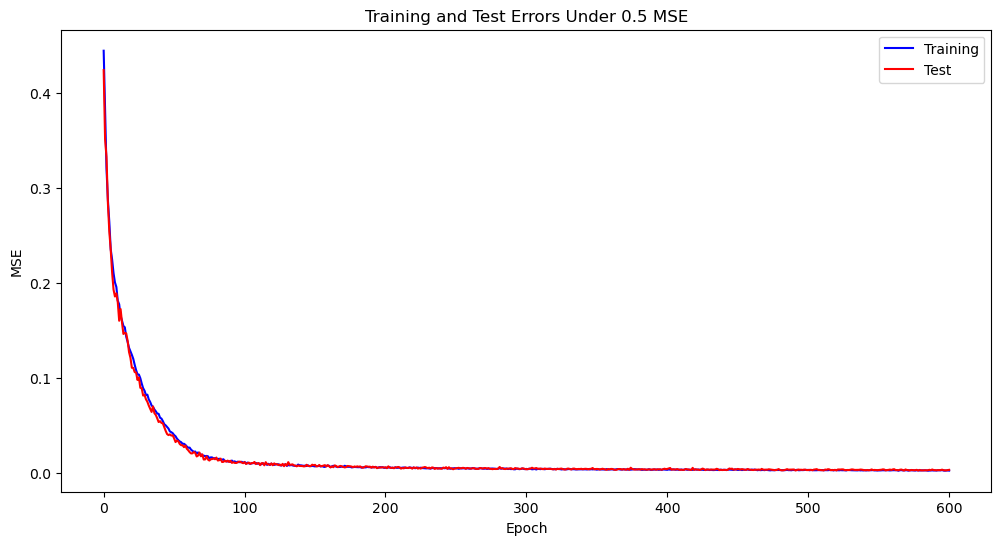

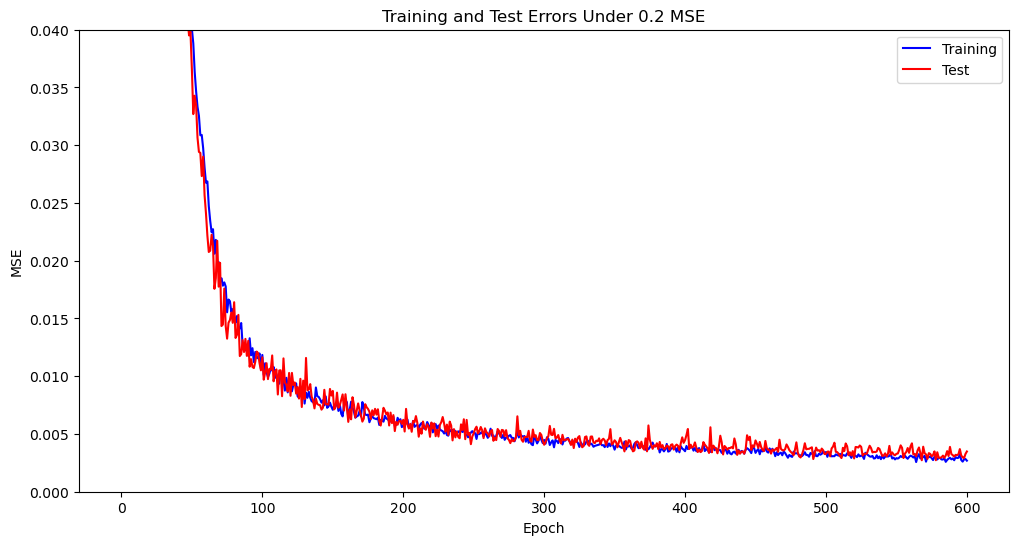

In [16]:
p = len(phi_columns) + len(covariates)

x = deposit_data[phi_columns + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),p)
x = x[:,[i for i in range(p)]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# model = nn.Sequential(
#     nn.Linear(in_features=p, out_features=1000),
#     nn.ReLU(),
#     nn.Linear(in_features=1000, out_features=1)
# )

model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5) ,
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))


mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(601):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')




# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.04)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()








In [17]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined
p = len(phi_columns) + len(covariates)
# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []



# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[phi_columns + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[phi_columns + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=p, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5) ,
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=1))


    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0025
  RMSE: 0.0500
  MAE: 0.0368
  R^2: 0.8431



KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=100, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(in_features=hidden_size, out_features=1)
        )

    def forward(self, x):
        return self.layers(x)

def train_and_evaluate(model, train_data, test_data, num_epochs=601, lr=0.001):
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for epoch in range(num_epochs):
        pre = model(torch.tensor(train_data['input'], dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(train_data['output'].reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(test_data['input'], dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(test_data['output'].reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    return test_losses

def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, covariates, and other necessary variables are defined
p = len(phi_columns) + len(covariates)

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[phi_columns + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[phi_columns + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Create and train the neural network
    model = NeuralNetwork(input_size=p)
    test_losses = train_and_evaluate(model, {'input': x_train, 'output': y_train}, {'input': x_test, 'output': y_test})

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0025
  RMSE: 0.0500
  MAE: 0.0368
  R^2: 0.8431


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0037
  RMSE: 0.0610
  MAE: 0.0424
  R^2: 0.7161


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0045
  RMSE: 0.0670
  MAE: 0.0401
  R^2: 0.6951


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0030
  RMSE: 0.0546
  MAE: 0.0404
  R^2: 0.7795


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0031
  RMSE: 0.0557
  MAE: 0.0423
  R^2: 0.8275


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0033
  RMSE: 0.0572
  MAE: 0.0408
  R^2: 0.7427


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0037
  RMSE: 0.0612
  MAE: 0.0437
  R^2: 0.7923


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0060
  RMSE: 0.0773
  MAE: 0.0526
  R^2: 0.6685


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0593
  MAE: 0.0428
  R^2: 0.7222


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0037
  RMSE: 0.0609
  MAE: 0.0430
  R^

# Better

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network with separate branches for phi_columns and covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=100),
            nn.Linear(in_features=100, out_features=1)
     
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=100),
            nn.Linear(in_features=100, out_features=1)       
          )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    x_train_covariates = train_data[covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    x_test_covariates = test_data[covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average
# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")


Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0582
  MAE: 0.0429
  R^2: 0.7881


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0602
  MAE: 0.0422
  R^2: 0.7231


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0047
  RMSE: 0.0688
  MAE: 0.0459
  R^2: 0.6788


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0035
  RMSE: 0.0588
  MAE: 0.0422
  R^2: 0.7440


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0603
  MAE: 0.0456
  R^2: 0.7977


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0562
  MAE: 0.0410
  R^2: 0.7516


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0023
  RMSE: 0.0476
  MAE: 0.0361
  R^2: 0.8744


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0054
  RMSE: 0.0733
  MAE: 0.0519
  R^2: 0.7021


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0034
  RMSE: 0.0582
  MAE: 0.0432
  R^2: 0.7330


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0599
  MAE: 0.0431
  R^

# Faster

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network with separate branches for phi_columns and covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
     
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=1)      
          )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    x_train_covariates = train_data[covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    x_test_covariates = test_data[covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average
# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")


Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0626
  MAE: 0.0448
  R^2: 0.7544


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0039
  RMSE: 0.0623
  MAE: 0.0452
  R^2: 0.7041


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0045
  RMSE: 0.0668
  MAE: 0.0477
  R^2: 0.6971


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0041
  RMSE: 0.0637
  MAE: 0.0442
  R^2: 0.6998


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0036
  RMSE: 0.0602
  MAE: 0.0454
  R^2: 0.7986


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0038
  RMSE: 0.0615
  MAE: 0.0456
  R^2: 0.7026


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0058
  RMSE: 0.0764
  MAE: 0.0525
  R^2: 0.6769


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0565
  MAE: 0.0423
  R^2: 0.8229


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0032
  RMSE: 0.0567
  MAE: 0.0422
  R^2: 0.7464


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0043
  RMSE: 0.0652
  MAE: 0.0473
  R^

In [ ]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=1)
        )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Instantiate your model
model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

# Create a dummy input tensor
dummy_input_phi = torch.randn(1, len(phi_columns))
dummy_input_covariates = torch.randn(1, len(covariates))

# Initialize a SummaryWriter for logging
writer = SummaryWriter()

# Log the model graph to TensorBoard
writer.add_graph(model, (dummy_input_phi, dummy_input_covariates))

# Close the SummaryWriter when finished
writer.close()


In [23]:


import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# Define your neural network architecture
model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5) ,
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))

# Create a dummy input tensor
dummy_input = torch.randn(100,len(phi_columns)+len(covariates))



# Initialize a SummaryWriter for logging
writer = SummaryWriter()

# Log the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the SummaryWriter when finished
writer.close()


In [24]:

%reload_ext tensorboard
%tensorboard --logdir="C:\Users\23478671\Github\PhD-Thesis---Incorporating-Deep-Learning-into-Statistical-Models-for-Spatial-Interpolation\Paper 3 PhD BNNs for multivariate predictions" --port 5001

Reusing TensorBoard on port 5001 (pid 11580), started 1 day, 4:36:08 ago. (Use '!kill 11580' to kill it.)

In [ ]:
import torch
from torchviz import make_dot

# Assuming input_size_phi and input_size_covariates are known
input_size_phi = len(phi_columns)
input_size_covariates = len(covariates)

# Instantiate your model
model = GroupedNet(input_size_phi, input_size_covariates, output_size=1)

# Dummy input


# Forward pass
output = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))

# Visualize the model
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("grouped_net_visualization", format="png", cleanup=True)


'grouped_net_visualization.png'

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_mae_list = []
test_r2_list = []

# Initialize an array to accumulate gradients for the first layer of combine_layer
total_gradients_combine_layer = torch.zeros(1)  # Initialize as a tensor

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a neural network with separate branches for phi_columns and covariates
class GroupedNet(nn.Module):
    def __init__(self, input_size_phi, input_size_covariates, output_size):
        super(GroupedNet, self).__init__()
        self.phi_branch = nn.Sequential(
            nn.Linear(in_features=input_size_phi, out_features=1)
        )
        self.covariates_branch = nn.Sequential(
            nn.Linear(in_features=input_size_covariates, out_features=1)
        )
        
        self.combine_layer = nn.Sequential(
            nn.Linear(2, 100), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(in_features=100, out_features=1)
        )
                                           

    def forward(self, input_phi, input_covariates):
        phi_output = self.phi_branch(input_phi)
        covariates_output = self.covariates_branch(input_covariates)
        x = torch.cat((phi_output, covariates_output), dim=1)
        output = self.combine_layer(x)
        return output

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train_phi = train_data[phi_columns].values
    x_train_covariates = train_data[covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test_phi = test_data[phi_columns].values
    x_test_covariates = test_data[covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = GroupedNet(input_size_phi=len(phi_columns), input_size_covariates=len(covariates), output_size=1)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train_phi, dtype=torch.float32), torch.tensor(x_train_covariates, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()

        # Accumulate gradients for the first layer of combine_layer
# Accumulate gradients for the first layer of combine_layer
        total_gradients_combine_layer += model.combine_layer[0].weight.grad  # Use model.combine_layer[0] instead of model.combine_layer[0][0]

        optimizer.step()

        pre_test = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test_phi, dtype=torch.float32), torch.tensor(x_test_covariates, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Calculate average gradients for the first layer of combine_layer
average_gradients_combine_layer = total_gradients_combine_layer / num_folds

# Print average gradients
print("\nAverage Gradients of the First Layer of combine_layer:", average_gradients_combine_layer)


RuntimeError: output with shape [1] doesn't match the broadcast shape [100, 2]